In [1]:
!pip install gpytorch


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
from linear_operator.operators import DenseLinearOperator

%matplotlib inline
torch.manual_seed(0)


## Probem definition

In [18]:
def f(x):
    #return (x - 1/2)**2
    return x * torch.sin(x)



# Training data is 100 points in [0,1] regularly spaced 
train_x = torch.linspace(-5, 5, 20)
extra_point = torch.tensor([10])   # far away and not equispaced
train_x = torch.cat((train_x, extra_point))


train_y = f(train_x)



## GP model

In [19]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel() )

        #self.covar_module.base_kernel.period_length = 2 * math.pi



    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)





## Training

In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood( noise_constraint=gpytorch.constraints.GreaterThan(1e-8))

likelihood.noise = torch.tensor(1e-8)
likelihood.raw_noise.requires_grad_(False) #para no optimizar el ruido

model = ExactGPModel(train_x, train_y, likelihood)


model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    """print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, 50, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))"""

    optimizer.step()


## Prediction

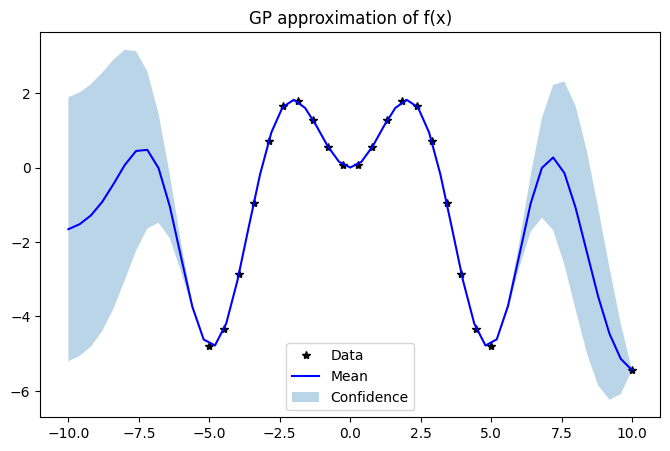

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-10, 10, 51)
    observed_pred = likelihood(model(test_x))


with torch.no_grad():
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

plt.figure(figsize=(8,5))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Data')
plt.plot(test_x.numpy(), mean.numpy(), 'b', label='Mean')
plt.fill_between(
    test_x.numpy(),
    lower.numpy(),
    upper.numpy(),
    alpha=0.3,
    label='Confidence'
)

plt.title("GP approximation of f(x)")
plt.legend()
plt.show()




 # SOLVE PDE


## kernel

In [22]:
def rbf_kernel(x, xp, lengthscale=0.5, variance=1.0):
    r = (x - xp.T) ** 2
    return variance * torch.exp(-0.5 * r / lengthscale**2)

def d2_rbf_dx2(x, xp, lengthscale=0.5, variance=1.0):
    k = rbf_kernel(x, xp, lengthscale, variance)
    return k * ((x - xp.T)**2 / lengthscale**4 - 1.0 / lengthscale**2)

def d2d2_rbf(x, xp, lengthscale=0.5, variance=1.0):
    k = rbf_kernel(x, xp, lengthscale, variance)
    r2 = (x - xp.T)**2
    l2 = lengthscale**2
    return k * (r2**2 / l2**4 - 6*r2 / l2**3 + 3 / l2**2)


## Boundary conditions and interior points

In [8]:
x_u = torch.tensor([[-1.0], [1.0]])
y_u = torch.tensor([[9/4], [1/4]]) #boundary conditions

x_f = torch.linspace(-1, 1, 20).unsqueeze(-1)
y_f = 2.0 * torch.ones_like(x_f)


## Covariance matrix

In [9]:
l = 0.4
var = 1.0
noise = 1e-6

K_uu = rbf_kernel(x_u, x_u, l, var)
K_uf = d2_rbf_dx2(x_u, x_f, l, var)
K_fu = K_uf.T
K_ff = d2d2_rbf(x_f, x_f, l, var)


K = torch.cat([torch.cat([K_uu, K_uf], dim=1),torch.cat([K_fu, K_ff], dim=1)], dim=0)


## Mean and variance


In [10]:
y = torch.cat([y_u, y_f], dim=0)
x_star = torch.linspace(-1, 1, 200).unsqueeze(-1)

K_su = rbf_kernel(x_star, x_u, l, var)
K_sf = d2_rbf_dx2(x_star, x_f, l, var)
K_s = torch.cat([K_su, K_sf], dim=1)

K_ss = rbf_kernel(x_star, x_star, l, var)

alpha = torch.linalg.solve(K, y)
mean = K_s @ alpha

cov = K_ss - K_s @ torch.linalg.solve(K, K_s.T)
std = torch.sqrt(torch.diag(cov))


## Plot the result

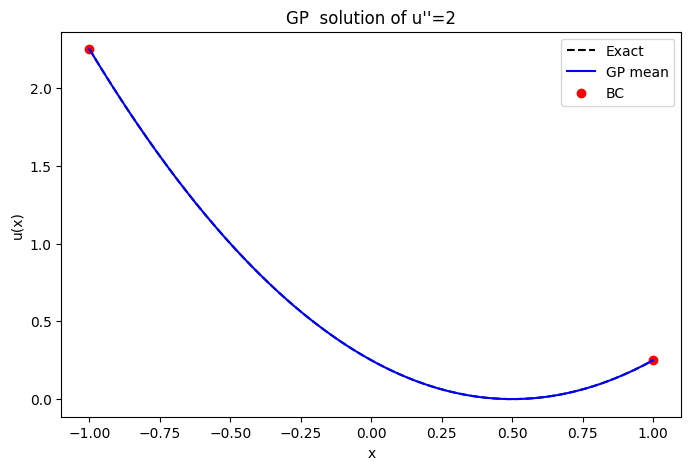

In [11]:
u_exact = x_star.squeeze()**2 - x_star.squeeze() + 0.25
plt.figure(figsize=(8,5))
plt.plot(x_star, u_exact, 'k--', label='Exact')
plt.plot(x_star, mean, 'b', label='GP mean')
plt.fill_between(
    x_star.squeeze(),
    (mean.squeeze() - 2*std),
    (mean.squeeze() + 2*std),
    alpha=0.3
)
plt.scatter(x_u, y_u, c='red', label='BC')
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("GP  solution of u''=2")
plt.show()


## Another way

In [29]:
def rbf(x, xp, l, var):
    # x: (N,1), xp: (M,1)
    r2 = (x - xp.T) ** 2
    return var * torch.exp(-0.5 * r2 / (l**2))

def d2_rbf_dx2(x, xp, l, var):
    # second derivative w.r.t. the variable x (lo mismo que para xp)
    k = rbf(x, xp, l, var)
    r2 = (x - xp.T) ** 2
    l2 = l**2
    return k * (r2 / (l2**2) - 1.0 / l2)

def d2d2_rbf(x, xp, l, var):
    # d^2/dx^2 d^2/dxp^2 k(x,xp)
    k = rbf(x, xp, l, var)
    r2 = (x - xp.T) ** 2
    l2 = l**2
    return k * (r2**2 / (l2**4) - 6.0 * r2 / (l2**3) + 3.0 / (l2**2))


#  task 0 = u, task 1 = u''
class DerRBFKernel(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, init_lengthscale=0.4, init_variance=1.0):
        super().__init__()
        self.base_kernel= gpytorch.kernels.RBFKernel()
        self.outputscale = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x1, x2, diag=False, **params):
        # x1, x2: (N,2) and (M,2) with [:,0]=location, [:,1]=task
        x1_loc = x1[:, 0:1] #primera columna (N,1)
        x2_loc = x2[:, 0:1]
        t1 = x1[:, 1].long()  # (N,)
        t2 = x2[:, 1].long()  # (M,)

        l = self.base_kernel.lengthscale
        var = self.outputscale.outputscale


        # Base and derivative blocks
        K00 = self.outputscale(x1_loc, x2_loc).to_dense() #coge el kernel y lo trnasforma en matriz
        K10 = d2_rbf_dx2(x1_loc, x2_loc, l, var)  # d^2/dx^2 k
        K01 = d2_rbf_dx2(x1_loc, x2_loc, l, var) # d^2/dx'^2 k (same formula for RBF)
        K11 = d2d2_rbf(x1_loc, x2_loc, l, var)

        #Assemble according to task pairs
        #masks: (N,M)
        t1m = t1[:, None]
        t2m = t2[None, :]

        mask00=(t1m == 0) & (t2m == 0)
        mask01=(t1m == 0) & (t2m == 1)
        mask10=(t1m == 1) & (t2m == 0)
        mask11=(t1m == 1) & (t2m == 1)

        K = torch.zeros_like(K00)
        K = K + mask00*K00
        K = K + mask01*K01
        K = K + mask10*K10
        K = K + mask11*K11

        if diag:
            return K.diag()

        return DenseLinearOperator(K)

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = DerRBFKernel(init_lengthscale=0.4, init_variance=1.0)

    def forward(self, x):
        mean_x = self.mean_module(x[:, 0:1])
        covar_x = self.covar_module(x, x)
        return gpytorch.distributions.MultivariateNormal(mean_x.squeeze(-1), covar_x)




#boundary points
#x_u = torch.tensor([[-1.0], [1.0]])
#y_u = torch.tensor([9/4, 1/4], dtype=torch.float32)  # (2,)

x_u = torch.tensor([[-5.0], [5.0]])
y_u = (x_u.squeeze() * torch.sin(x_u.squeeze())).to(torch.float32)


#PDE points
#x_f = torch.linspace(-5, 5, 20).unsqueeze(-1)
#y_f = 2.0 * torch.ones(x_f.shape[0], dtype=torch.float32)  # (20,)

# PDE points: enforce u''(x) = 2*cos(x) - x*sin(x)
x_f = torch.linspace(-5, 5, 50).unsqueeze(-1)  
xf = x_f.squeeze(-1)
y_f = (2.0 * torch.cos(xf) - xf * torch.sin(xf)).to(torch.float32)


#inputs are [x, task]
Xu = torch.cat([x_u, torch.zeros_like(x_u)], dim=1) # task=0
Xf = torch.cat([x_f, torch.ones_like(x_f)], dim=1) # task=1

train_x = torch.cat([Xu, Xf], dim=0) # (22,2)
train_y = torch.cat([y_u, y_f], dim=0)   # (22,)


likelihood = gpytorch.likelihoods.GaussianLikelihood( noise_constraint=gpytorch.constraints.GreaterThan(1e-6))

likelihood.noise = torch.tensor(1e-6)  # very small value instead of exactly 0
likelihood.raw_noise.requires_grad = False
model = ExactGP(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Predict u(x*) (task=0)
model.eval()
likelihood.eval()

x_star = torch.linspace(-5, 5, 200).unsqueeze(-1)
X_star_u = torch.cat([x_star, torch.zeros_like(x_star)], dim=1)  # task=0 (u)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = (model(X_star_u))
    mean_u = pred.mean
    lower_u, upper_u = pred.confidence_region()

print(
    "Trained lengthscale:",
    model.covar_module.base_kernel.lengthscale.item()
)
print(
    "Trained variance:",
    model.covar_module.outputscale.outputscale.item()
)
print(
    "Noise:",
    likelihood.noise.item()
)


# mean_u is the mean for u(x)


Trained lengthscale: 1.9895334243774414
Trained variance: 9.486410140991211
Noise: 9.999999974752427e-07


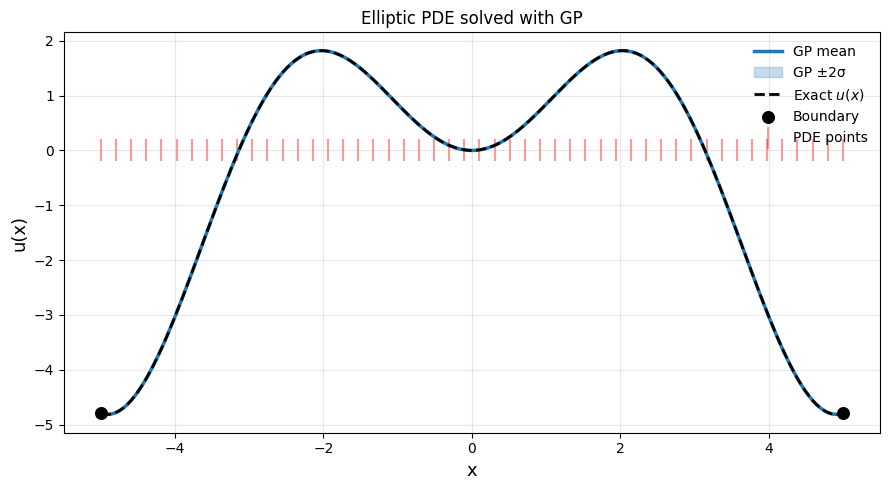

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# exact solution
u_exact = x_star.squeeze() * torch.sin(x_star.squeeze())
#u_exact=(x_star.squeeze()-1/2)**2


std_u = (upper_u - mean_u) / 2.0

plt.figure(figsize=(9,5))

# GP mean
plt.plot(
    x_star.squeeze(),
    mean_u,
    color="C0",
    lw=2.5,
    label="GP mean"
)

# GP uncertainty band
plt.fill_between(
    x_star.squeeze(),
    mean_u - 2*std_u,
    mean_u + 2*std_u,
    color="C0",
    alpha=0.25,
    label="GP ±2σ"
)

# exact solution
plt.plot(
    x_star.squeeze(),
    u_exact,
    "k--",
    lw=2,
    label=r"Exact $u(x)$"
)

# boundary conditions
plt.scatter(
    x_u.squeeze(),
    y_u,
    color="black",
    s=70,
    zorder=5,
    label="Boundary"
)

# PDE collocation points (projected on x-axis)
plt.scatter(
    x_f.squeeze(),
    torch.zeros_like(x_f.squeeze()),
    color="red",
    marker="|",
    s=250,
    alpha=0.4,
    label="PDE points"
)

plt.xlabel("x", fontsize=13)
plt.ylabel("u(x)", fontsize=13)
plt.title("Elliptic PDE solved with GP")

plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




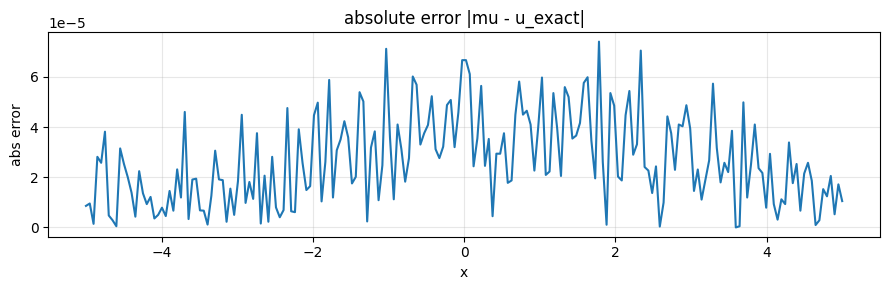

In [32]:
u_ex = x_star.squeeze() * torch.sin(x_star.squeeze())
#u_ex=(x_star.squeeze()-1/2)**2
err = mean_u - u_ex
abs_err = err.abs()
plt.figure(figsize=(9,3))
plt.plot(x_star.squeeze(), abs_err)
plt.title("absolute error |mu - u_exact|")
plt.xlabel("x"); plt.ylabel("abs error")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
